In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import multipletau
from scipy import optimize

from kinetic_function import (fit_function,
                              read_csv_file, 
                              single_track_analysis,
                              autocorrelation,
                              fit_autocorrelation,
                             )

In [16]:
PROTEIN_SIZE = 1200
DELTA_T = 0.39

In [17]:
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/01-Cyril_Morgane/"
files = [
        "trackCyril_0_mean_intensity.csv",
]


# Single track analysis

In [18]:
# datas = read_csv_file(path+files[0])
datas = pd.read_csv(path+files[0]).T
datas.drop(index=["Frame number"], inplace=True)

In [19]:
# print(np.unique(datas.TRACK_ID))
datas.head()

,0,1,2,3,4,5,6,7,8,9,...,570,571,572,573,574,575,576,577,578,579
mhtTracks-Run1#0,376.833333,470.657143,240.371795,360.805556,149.692308,117.897436,538.119048,310.846154,113.200000,-52.283333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#1,330.383333,375.750000,394.833333,449.444444,297.100000,356.583333,42.226190,12.329365,-67.710317,341.683992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#2,311.626068,894.031746,28.259875,401.896050,-69.128205,-120.564103,-369.384615,-226.897436,614.023923,65.301619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#3,402.914286,673.387560,440.416667,734.000000,309.315789,525.452991,1211.630952,1313.150794,1500.568421,1105.191667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#4,NaN,632.222222,537.666667,735.070513,491.721053,259.222222,-117.343434,-51.452020,-98.270202,-59.883838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
tracks = []
for i, val in datas.iterrows():
    if (len(val.to_numpy()[~np.isnan(val.to_numpy())])) > 80:
        print(i)
        tracks.append(i)

mhtTracks-Run1#7
mhtTracks-Run1#47
mhtTracks-Run1#99
mhtTracks-Run1#100
mhtTracks-Run1#112
mhtTracks-Run1#120
mhtTracks-Run1#133
mhtTracks-Run1#158
mhtTracks-Run1#166
mhtTracks-Run1#171
mhtTracks-Run1#185
mhtTracks-Run1#209
mhtTracks-Run1#223
mhtTracks-Run1#245


In [21]:
def single_track_analysis(datas, 
                          id_track=0, 
                          delta_t=0.5, 
                          protein_size=1500, 
                          normalise_intensity=2 ** 16 * 100):
    
    y = datas.loc[id_track].values
    y = y[~np.isnan(y)]
    
    x = np.arange(len(y))*delta_t
    
    x_auto, y_auto = autocorrelation(y, delta_t, True)
    
    elongation_r, translation_init_r = fit_autocorrelation(x_auto, y_auto, fit_function, protein_size=protein_size)

    return x, y, x_auto, y_auto, elongation_r, translation_init_r

In [22]:
id_track = "mhtTracks-Run1#100"
x, y, x_auto, y_auto, elongation_r, translation_init_r = single_track_analysis(datas, 
                                                                               id_track, 
                                                                               delta_t = 5,
                                                                               protein_size=PROTEIN_SIZE,
                                                                               normalise_intensity=1)
print(elongation_r, translation_init_r)

original method
611.7364856307283 2.0794685369254604


/home/u2175049/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


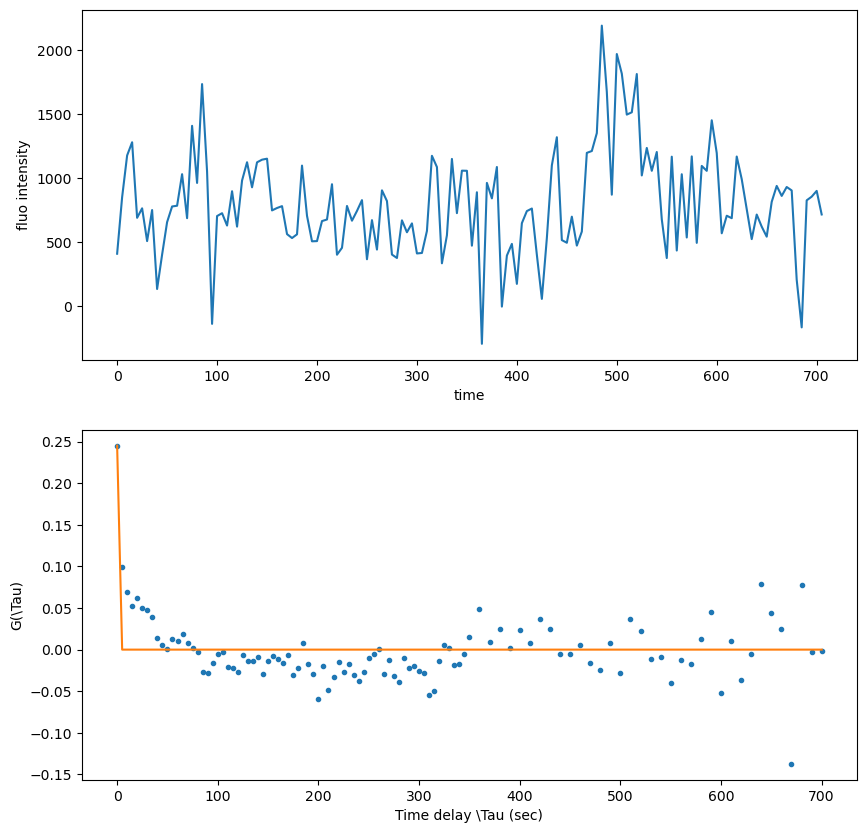

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(x,y)
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")

ax[1].plot(x_auto, y_auto, '.')
ax[1].plot(x_auto, fit_function(x_auto, PROTEIN_SIZE/elongation_r, translation_init_r) )
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
fig.set_size_inches((10,10))

# plot all track that was keep in result table

In [29]:
columns = ['track_id','len_track', 'elongation_time', 'init_translation_rate', 'decorr_time']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]


# tracks = [
#     "mhtTracks-Run1#100",
#     "mhtTracks-Run1#120",
#     "mhtTracks-Run1#133",
#     "mhtTracks-Run1#158",
#     "mhtTracks-Run1#171",
#     "mhtTracks-Run1#185",
#     "mhtTracks-Run1#209",
#     "mhtTracks-Run1#223",
#     "mhtTracks-Run1#245",
# ]

for id_track in tracks:
    x, y, x_auto, y_auto, elongation_r, translation_init_r = single_track_analysis(datas, 
                                                                               id_track, 
                                                                               delta_t = DELTA_T,
                                                                               protein_size=PROTEIN_SIZE)
#     print(PROTEIN_SIZE/elongation_r)
    if (elongation_r)>5:
        d = pd.DataFrame.from_dict({
                                    'track_id':id_track,
                                    'len_track': len(x),
                                    'elongation_time':elongation_r,
                                    'init_translation_rate':translation_init_r,
                                    'decorr_time': PROTEIN_SIZE/elongation_r},
                                   orient='index').T
        result = pd.concat([result, d], ignore_index=True)


# result['tmp'] = 1

original method
original method
original method
original method
original method
original method
original method
original method
original method
original method
original method
original method
original method
original method


In [30]:
result

,track_id,len_track,elongation_time,init_translation_rate,decorr_time
0,mhtTracks-Run1#7,96,1217.597445,3.660878,0.985547
1,mhtTracks-Run1#47,82,1264.683714,4.213672,0.948854
2,mhtTracks-Run1#99,87,373.600268,1.257259,3.211989
3,mhtTracks-Run1#100,142,1200.457838,4.423815,0.999619
4,mhtTracks-Run1#112,96,1182.840591,3.974613,1.014507
5,mhtTracks-Run1#120,152,521.33714,1.291946,2.301773
6,mhtTracks-Run1#133,149,1389.834105,4.029069,0.863412
7,mhtTracks-Run1#158,107,813.282003,3.214226,1.475503
8,mhtTracks-Run1#166,87,2257.638174,9.123029,0.531529
9,mhtTracks-Run1#171,117,1100.321921,2.488601,1.09059


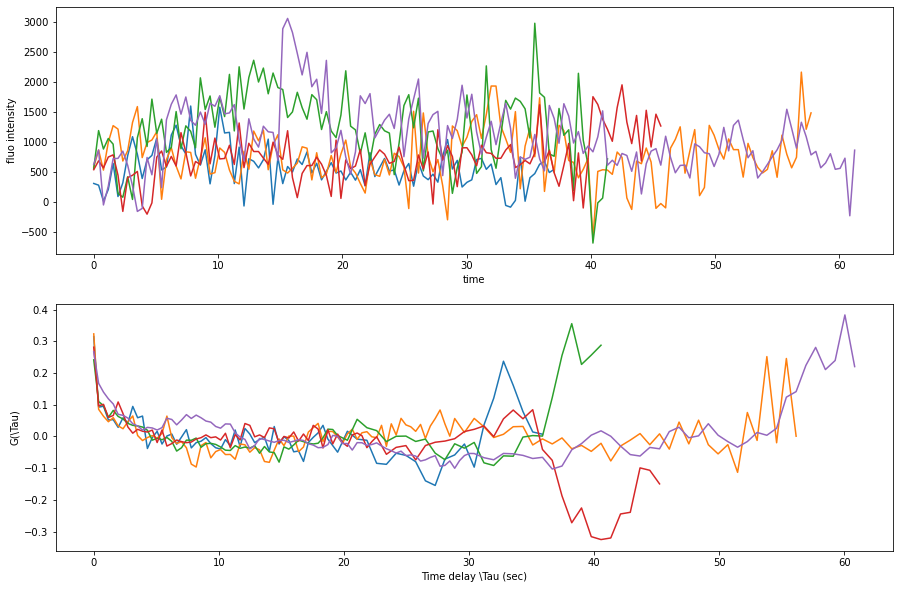

In [50]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(2,1)

colors = list(mcolors.TABLEAU_COLORS.keys())

i=0
# for id_track in tracks:
for id_track in result["track_id"]:


    x, y, x_auto, y_auto, elongation_r, translation_init_r = single_track_analysis(datas, 
                                                                               id_track, 
                                                                               delta_t = DELTA_T,
                                                                               protein_size=PROTEIN_SIZE)

    ax[0].plot(x, y, color=colors[i])
    ax[1].plot(x_auto,#-PROTEIN_SIZE/elongation_r, 
               y_auto, 
               '-', 
               color=colors[i])
#     ax[1].plot(x_auto,#-PROTEIN_SIZE/elongation_r, 
#                fit_function(x_auto, PROTEIN_SIZE/elongation_r, translation_init_r ), 
#                color=colors[i] )
    
    
    
    if i == 7:
        i=0
    else:
        i+=1

ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
# ax[1].set_xlim((1,20))
# ax[1].set_ylim((-0.1,0.2))
# ax[1].hlines(0, 0, 20, color='grey')


fig.set_size_inches((15,10))

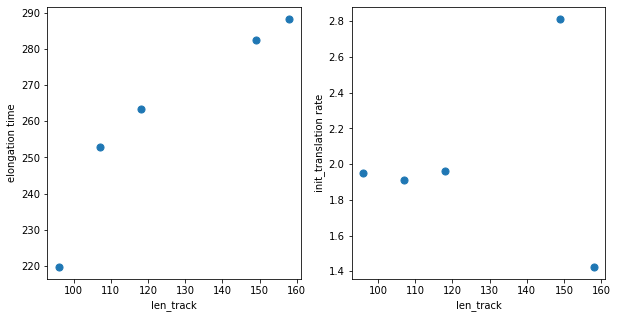

In [13]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(result['len_track'], result['elongation_time'], s=50)
ax[1].scatter(result['len_track'], result['init_translation_rate'], s=50)
ax[0].set_xlabel('len_track')
ax[0].set_ylabel('elongation time')

ax[1].set_xlabel('len_track')
ax[1].set_ylabel('init_translation rate')
fig.set_size_inches((10,5))

len_track                125.600000
elongation_time          261.384289
init_translation_rate      2.012695
decorr_time                4.633964
dtype: float64


/tmp/ipykernel_132999/2862878632.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(result.mean())


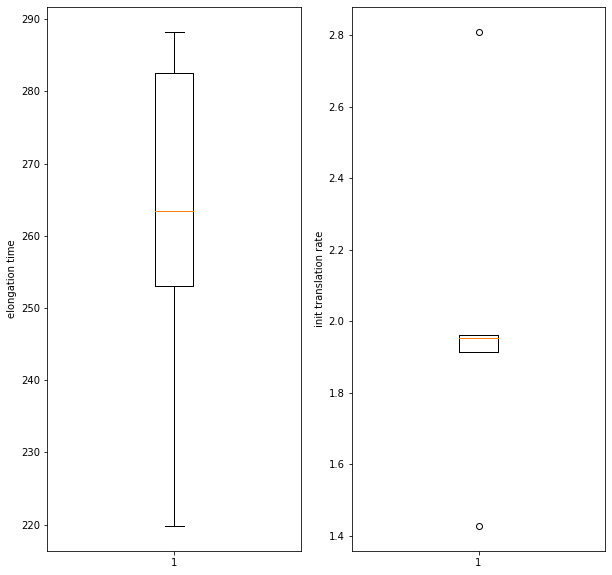

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].boxplot(result['elongation_time'])
ax[1].boxplot(result['init_translation_rate'])
ax[0].set_ylabel('elongation time')
ax[1].set_ylabel('init translation rate')
fig.set_size_inches((10,10))
print(result.mean())